# LangGraph

## Why LangGraph ?

LangChain was one of the first popular libraries for building LLM applications. It offers tools for prompts, chains, memory, and retrieval. But as people started building AI agents, multi-step workflows, and complex reasoning systems, several problems became obvious with LangChain.
- LangChain are Linear and Acyclic directed graph
    - Step 1 → Step 2 → Step 3 → Output and 
    - But real AI agents need:
        - loops
        - retries
        - branching decisions
        - conditional logic
        - cycles (think: try → evaluate → improve → try again)
    - No Built-in State Machine such as
        - conversation history
        - intermediate reasoning results
        - tools used
        - progress tracking 

All these are solved by the LangGraphs. LangGraph

- State Machine for AI Agents such as Think(Resoning) → Act → Observe → Think → Finish this is called (ReAct)
- With LangGraph allows to control:
    - loops
    - retries
    - branching
    - when the agent stops
    - LLM loops and Human In Loop
    - workflow orchestration
    - step-by-step tracing
    - checkpoints,versioning,logging each node clearly etc

- Built for Multi-turn Reasoning & Tool Use

This makes LangGraph the perfect fit for:
    - RAG agents
    - Coding agents
    - Troubleshooting agents
    - Planning agents
    - Multi-agent systems

## Basic Elements to Build AI Agent Using Graphs

- State: The memory or data the agent carries throughout its execution.
    - Holds anything the agent needs: messages, tools results, decisions, planning steps, etc.
    - Defined it as a Python class or typed dictionary.
    - Each node in the graph reads and updates this state.
- Node: Nodes are the individual steps or functions in your agent workflow.
    - A node is python function and processes the current state
    - Nodes can call tools, use an LLM, or apply logic.
    - They return an updated state.
- Edges: Edges connect nodes and determine what runs next. Edges enable loops, branching, and multi-step reasoning — something LangChain struggles with.
    - Normal edges (Node A → Node B)
    - Conditional edges
    - A python fucntion, if model says "use tool": go to tool node else go to finish node

Combining all these together, we can build the StateGraphs using LangChain to achieve a specific task



## LangGraph Usage

#### Set up

In [1]:
from langgraph.graph import StateGraph,START, END
from langchain_core.messages import AnyMessage,BaseMessage
from typing_extensions import TypedDict, Annotated,Sequence, List
import operator


#### Simple Graph Using the LangGraph


In [5]:
def node1(inp):
    print("Hello from node 1")
    return inp

def node2(inp):
    print("Hello from node 2")
    return inp


class MessageState(TypedDict):
    messages: Annotated[List[str], operator.add]
    #messages: Annotated[list[AnyMessage], operator.add]

simplegraph= StateGraph(MessageState)

simplegraph.add_node("Node1",node1)
simplegraph.add_node("Node2",node2)
simplegraph.add_edge("Node1","Node2")
simplegraph.set_entry_point("Node1")
simplegraph.set_finish_point("Node2")

app=simplegraph.compile()
app.get_graph()


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'Node1': Node(id='Node1', name='Node1', data=Node1(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'Node2': Node(id='Node2', name='Node2', data=Node2(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='Node1', target='Node2', data=None, conditional=False), Edge(source='__start__', target='Node1', data=None, conditional=False), Edge(source='Node2', target='__end__', data=None, conditional=False)])

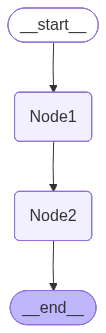

In [6]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
app.invoke({"message":"chandra"})

Hello from node 1
Hello from node 2


{'messages': []}

#### Simple RAG using LangGraph

In [25]:
#import necessary libraries.
import os
import warnings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AnyMessage
from langchain import hub
from dotenv import load_dotenv
warnings.filterwarnings('ignore')
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
hug_embeds=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")
from langchain_openai import ChatOpenAI


In [9]:
## Vector DB
vector_store_docs_ondisk=FAISS.load_local("./data/faiss/humanevolution",embeddings=hug_embeds,allow_dangerous_deserialization=True)
vector_store_docs_ondisk.similarity_search(query= "What is human evolution interm of enineering ?", k=4)

[Document(id='d77ca5d2-ad17-48a0-b236-dac6ff41b5e2', metadata={'source': './data/human_evolution.txt'}, page_content='Human evolution is the long biological and cultural process through which modern humans emerged from earlier hominin ancestors. Humanity’s story begins with early primates that adapted to life in'),
 Document(id='32147bb7-b914-43e1-876b-7c550a9e71ef', metadata={'source': './data/human_evolution.txt'}, page_content='Technological advances such as metalworking, navigation, and engineering reshaped human interactions with the environment. Cultural evolution began to outpace biological evolution, allowing rapid'),
 Document(id='277ae968-ba1e-4430-8d8f-5c7c444cb4e6', metadata={'source': './data/human_evolution.txt'}, page_content='change, now influence the future direction of human adaptation. Biological evolution continues, though cultural and technological evolution shape human lives more strongly. Today’s humans remain part'),
 Document(id='a068ee2e-91eb-482f-a8dc-c2c91c9

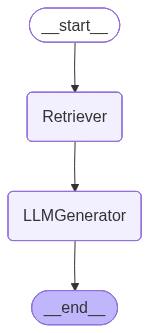

In [ ]:
class MessageState(TypedDict):
    messages: Annotated[List[str], operator.add]

def node1(state:MessageState):
    message=state["messages"][-1]
    print("Hello from node 1 as retriever")

    ## Retrieve the context
    context_docs=vector_store_docs_ondisk.similarity_search(query= message, k=4)
    retrieved_context="\n\n".join(doc.page_content for doc in context_docs)
    print("----- Retrived Context ---------")
    print(retrieved_context)
    print("--------------------------------")
    return {"messages":[retrieved_context]}

def node2(state:MessageState):
    print("Hello from node 2 as LLM Generator")
    prompt = hub.pull("rlm/rag-prompt")
    llm=ChatOpenAI(model="o3-mini")
    generator = prompt | llm | StrOutputParser()
    generated_output=generator.invoke({"context":state["messages"][-1], "question":state["messages"][0]})
    print("----- Generated Content ---------")
    print(generated_output)
    print("---------------------------------")
    return {"messages":[generated_output]}

simplegraph= StateGraph(MessageState)
simplegraph.add_node("Retriever",node1)
simplegraph.add_node("LLMGenerator",node2)
simplegraph.add_edge("Retriever","LLMGenerator")
simplegraph.set_entry_point("Retriever")
simplegraph.set_finish_point("LLMGenerator")
app=simplegraph.compile()
app.get_graph()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
app.invoke({"messages":["What is human evolution interms of enineering ?"]})

Hello from node 1 as retriever
----- Retrived Context ---------
Human evolution is the long biological and cultural process through which modern humans emerged from earlier hominin ancestors. Humanity’s story begins with early primates that adapted to life in

Technological advances such as metalworking, navigation, and engineering reshaped human interactions with the environment. Cultural evolution began to outpace biological evolution, allowing rapid

change, now influence the future direction of human adaptation. Biological evolution continues, though cultural and technological evolution shape human lives more strongly. Today’s humans remain part

became integral parts of human identity. Over time, societies developed political structures, laws, and shared belief systems that guided collective behavior. Human populations adapted biologically
--------------------------------
Hello from node 2 as LLM Generator
----- Generated Content ---------
Human evolution in terms of engineering r

{'messages': ['What is human evolution interms of enineering ?',
  'Human evolution is the long biological and cultural process through which modern humans emerged from earlier hominin ancestors. Humanity’s story begins with early primates that adapted to life in\n\nTechnological advances such as metalworking, navigation, and engineering reshaped human interactions with the environment. Cultural evolution began to outpace biological evolution, allowing rapid\n\nchange, now influence the future direction of human adaptation. Biological evolution continues, though cultural and technological evolution shape human lives more strongly. Today’s humans remain part\n\nbecame integral parts of human identity. Over time, societies developed political structures, laws, and shared belief systems that guided collective behavior. Human populations adapted biologically',
  'Human evolution in terms of engineering refers to how technological innovations like metalworking, navigation, and other enginee

#### Reasoning/Supervisor Node and Condition Edges.
- **Reasoning Nodes** are steps where the AI thinks or makes decisions about what to do next.
- **Condition Edges** decide the next step based on a rule, result, or situation.
Together enable AI agent to follow different paths depending on the context.
- **Example:** Imagine an AI helping a student with homework. A reasoning node checks if the student’s question is about India or Not. A condition edge then sends it to a “solve math problem” node if it’s math, or a “give history facts” node if it’s history.


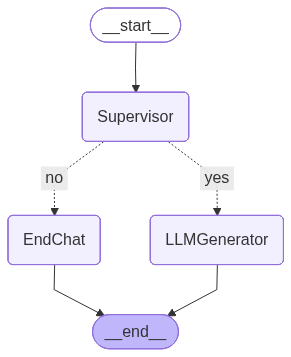

In [50]:
class MessageState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]
    # Previously we used string based messages. now let's use LangChain Prompts formats for messages

llm=ChatOpenAI(model="o3-mini")

def node1(state: MessageState):
    print("Hello from node 1 as Supervisor")

    prompt = ChatPromptTemplate.from_messages(
                                [
                                    ("system","You are a helpful assistant to classify whether input is related to India or Not and Expected Output is Yes if input is related to India and No otherwise. "),
                                    ("human", "{user_input}"),
                                ])

    
    chain = prompt | llm | StrOutputParser()
    
    output = chain.invoke({"user_input": state["messages"][0].content})
    print(f"the predicted output is {output}")
    print("---------------------------------")
    return {"messages": [AIMessage(content=output)]}

def node2(state:MessageState):
    print("Hello from node 2 as LLMGenerator")
    prompt=ChatPromptTemplate.from_messages(
                                [("system","Generate answer in 3 sentenses for given input"),
                               ("human","{user_input}")
                               ])
    chain=prompt | llm | StrOutputParser()
    generated_output=chain.invoke({"user_input":state["messages"][0].content})
    print("----- Generated Content ---------")
    print(generated_output)
    print("---------------------------------")
    return {"messages":[AIMessage(content=generated_output)]}

def node3(state:MessageState):
    print("The chat is ended as the Query is not related to India")
    return {"messages":[HumanMessage(content="Chat is Ended")]}

def conditional_router(state:MessageState):
    print("Hello from router")
    if "yes" in state["messages"][-1].content.lower():
        return "yes"
    else:
        return "no"

conditionalgraph= StateGraph(MessageState)
conditionalgraph.add_node("Supervisor",node1)
conditionalgraph.add_node("LLMGenerator",node2)
conditionalgraph.add_node("EndChat",node3)
conditionalgraph.set_entry_point("Supervisor")
conditionalgraph.add_conditional_edges("Supervisor",conditional_router, {"yes":"LLMGenerator","no":"EndChat"})
conditionalgraph.add_edge("LLMGenerator",END)
conditionalgraph.add_edge("EndChat",END)
app=conditionalgraph.compile()
app.get_graph()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [51]:
from langchain_core.messages import HumanMessage,AIMessage
app.invoke({"messages":[HumanMessage(content="What is the GDP of india in 2020?")]})

Hello from node 1 as Supervisor
the predicted output is Yes
---------------------------------
Hello from router
Hello from node 2 as LLMGenerator
----- Generated Content ---------
In 2020, India’s nominal GDP was estimated to be around USD 2.66 trillion. This period was marked by the significant economic impact of the COVID-19 pandemic, which contributed to a contraction in overall economic activity. Note that estimates can vary slightly depending on the data source and specific measurement methods used.
---------------------------------


{'messages': [HumanMessage(content='What is the GDP of india in 2020?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes', additional_kwargs={}, response_metadata={}),
  AIMessage(content='In 2020, India’s nominal GDP was estimated to be around USD 2.66 trillion. This period was marked by the significant economic impact of the COVID-19 pandemic, which contributed to a contraction in overall economic activity. Note that estimates can vary slightly depending on the data source and specific measurement methods used.', additional_kwargs={}, response_metadata={})]}

## Tool Calling

**Tool calling** in Agentic AI means the AI can use external tools—like calculators, search engines, databases, or APIs—to get accurate information or perform tasks it cannot do on its own.
Instead of guessing, the AI decides when to call a tool, sends the right inputs, gets the result, and uses it to continue its reasoning.
This makes the AI more reliable, useful, and capable of solving real-world problems.

**Example:**
A user asks an AI, “What’s the distance between New York and Boston?”
The AI realizes it needs accurate data, so it calls a **map API tool** to fetch the real distance.
The tool returns “346 km,” and the AI gives the correct answer instead of guessing.


#### Simple tool calling without LLMs using LangGraphs

In [69]:
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage,HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [85]:
llm.invoke("What is the temperature today in hyd ?")

AIMessage(content='I’m sorry, but I can’t access real-time weather data. For the latest temperature in Hyderabad (if that’s the “hyd” you meant), I recommend checking a reliable weather website or app like the Weather Channel, AccuWeather, or a local weather service for the most accurate and up-to-date information.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 461, 'prompt_tokens': 14, 'total_tokens': 475, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_4cd4f3e64a', 'id': 'chatcmpl-ClIp2jQWA3G8rUEZnUpAqKaFLHjZE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b096e-a0c7-7840-906b-46511cb5be60-0', usage_metadata={'input_tokens': 14, 'output_tokens': 461, 'total_tokens': 475, 'input_

In [80]:
@tool
def weather_search(query:str):
    """this is dummy fucntion for Hyderabad"""
    print('Inside weather search tool')
    if "hyderabad" in query.lower():
        return "weather in hyderabad is 25, sunny and windy"
    return "No weather inforamation available"

def weather_node(state:ToolMessagesState):
    print("Inside Weather Node")
    user_query = state["messages"][-1]  # last message
    result = weather_search.invoke({"query": user_query})
    return {"messages": [result]}


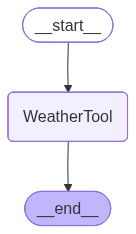

In [81]:
## MessageState
class ToolMessagesState(TypedDict):
    messages: Annotated[List[str], operator.add]

toolworkflow=StateGraph(ToolMessagesState)
toolworkflow.add_node("WeatherTool",weather_node)
toolworkflow.add_edge(START,"WeatherTool")
toolworkflow.add_edge("WeatherTool",END)
app=toolworkflow.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [83]:
app.invoke({"messages": ["What is the weather in Bengaluru?"]})


Inside Weather Node
Inside weather search tool


{'messages': ['What is the weather in Bengaluru?',
  'No weather inforamation available']}

#### Tooling Binding with LLMs using LangGraph


llm.bind_tools() feature used to attach tool definitions directly to an LL to make it aware of the what are the tools available based on the user input

In [92]:
@tool
def weather_search(query:str):
    """this is weather for Hyderabad"""
    print('Inside weather search tool')
    if "hyderabad" in query.lower():
        return "weather in hyderabad is 25, sunny and windy"
    return "No weather inforamation available"

@tool
def add(a: int, b: int):
    """This function is to add two variables"""
    return a + b


In [ ]:
tools=[weather_search]
llm_with_tool=llm.bind_tools(tools) #LLM aware of two tools

In [94]:
"""
if response = llm.invoke("What is 5 + 7?") it might produce following json
{
  "tool": "add",
  "a": 5,
  "b": 7
}

if you run llm.invoke("What's the weather in Delhi?") , it might product following output 

{
"tool": "weather_tool", 
"city": "Hyderabad"
}

"""

'\nif response = llm.invoke("What is 5 + 7?") it might produce following json\n{\n  "tool": "add",\n  "a": 5,\n  "b": 7\n}\n\nif you run llm.invoke("What\'s the weather in Delhi?") , it might product following output \n\n{\n"tool": "weather_tool", \n"city": "Hyderabad"\n}\n\n'

In [ ]:
response=llm_with_tool.invoke("what is a weather is Hyderabad?")
response.content

''

In [97]:
response.tool_calls

[{'name': 'weather_search',
  'args': {'query': 'Hyderabad'},
  'id': 'call_vqJOGNhWPcLWUwB8yr50BX6C',
  'type': 'tool_call'}]

In [ ]:
response=llm_with_tool.invoke("what is Artificial Intelligence?")
response.content

'Artificial Intelligence (AI) refers to the field of computer science that focuses on creating systems capable of performing tasks that typically require human intelligence. These tasks can include learning, reasoning, problem-solving, perception, language understanding, and even recognizing emotions. AI leverages algorithms, data, and computing power to mimic or simulate cognitive functions, enabling machines to analyze data, make decisions, and improve over time through experiences.\n\nSome key areas within AI include:\n\n• Machine Learning: A subset of AI where algorithms learn from data and improve their performance over time without being explicitly programmed.\n\n• Neural Networks: Inspired by the human brain, these are computing systems that process information in layers and are commonly used for pattern recognition and learning.\n\n• Natural Language Processing (NLP): Focused on the interaction between computers and human language, allowing machines to understand and generate h

In [107]:
response.tool_calls

[]

In [103]:
def call_model(state:ToolMessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

tool_node=ToolNode(tools)


def router_function(state: ToolMessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

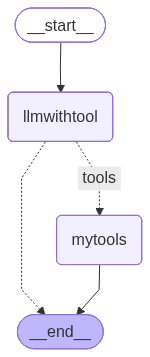

In [104]:
toolworkflow=StateGraph(ToolMessagesState)
toolworkflow.add_node("llmwithtool",call_model)
toolworkflow.add_node("mytools",tool_node)
toolworkflow.add_edge(START,"llmwithtool")
toolworkflow.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools":"mytools",
                                 END:END})

app=toolworkflow.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
response=app.invoke({"messages":["what is a weather in Hyderabad?"]})
response[""]

Inside weather search tool


{'messages': ['what is a weather in Hyderabad?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sRhDcMzFWGNcPYQPenOCz046', 'function': {'arguments': '{"query": "Hyderabad"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 158, 'prompt_tokens': 75, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_d83b50479d', 'id': 'chatcmpl-ClJQRnWcASV1afAUkBnbKHpOK3vRQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b0992-050c-7ff0-a5d5-c67a2d1b031b-0', tool_calls=[{'name': 'weather_search', 'args': {'query': 'Hyderabad'}, 'id': 'call_sRhDcMzFWGNcPYQPenOCz046', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, '

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


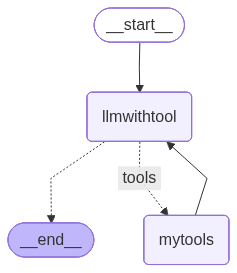

In [108]:
toolworkflow.add_edge("mytools","llmwithtool")
app=toolworkflow.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [109]:
for output in app.stream({"messages":["what is a weather in Hyderabad?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("-------------------------")
        print(value)
        print("\n")

here is output from llmwithtool
-------------------------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4JrbwFKofFvqvViTulqEmgDG', 'function': {'arguments': '{"query": "Hyderabad"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 75, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_ddf739c152', 'id': 'chatcmpl-ClJoiy8BhlemuxcasKWtiTA5SykcA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b09a8-fb41-74c3-98f9-552928f57491-0', tool_calls=[{'name': 'weather_search', 'args': {'query': 'Hyderabad'}, 'id': 'call_4JrbwFKofFvqvViTulqEmgDG', 'type': 'tool_call'}], usage_metadata={'i

#### Using mutilple tools (ReAct Graph)

In [ ]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

In [148]:
from langchain_community.tools import DuckDuckGoSearchResults

search = DuckDuckGoSearchResults()

results = search.invoke("What is the  Age of Narendra Modi")
print(results)

/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


snippet: Apr 29, 2025 · 界面简洁：age动漫动画官网的界面非常简洁明了，用户可以轻松上手。 操作简便：软件的操作流程简单易懂，即使是新手也能快速掌握。, title: age动漫动画官方正版入口 age动漫动画官网地址_百度知道, link: https://zhidao.baidu.com/question/996177558565754899.html, snippet: May 1, 2025 · 以下是关于age动漫动画官方正版入口的详细介绍： 官方正版保障：通过官方正版入口访问age动漫动画网站，观众可以确保获取到的是最新、最全且经过官方授权的动画作品。, title: age动漫动画官方正版入口_百度知道, link: https://zhidao.baidu.com/question/630028406680728012.html, snippet: May 19, 2024 · Age动漫官网是一个专门提供动漫内容在线观看的平台。 这个网站涵盖了各种类型的动漫作品，从经典老番到新番热播，内容丰富多样，满足了动漫迷们的不同需求。, title: Age动漫官网是哪个 - 百度知道, link: https://zhidao.baidu.com/question/252495963656055044.html, snippet: 1 day ago · Age of Empires II: DE II - Modding Discuss and share your custom mods for Age of Empires II: Definitive Edition. II - Report a Bug As with any game, there are bound to be errors …, title: Latest Age of Empires II: DE topics - Age of Empires Forum, link: https://forums.ageofempires.com/c/age-of-empires-ii/104


In [121]:
tools=[add,divide,multiply,search]
llm_with_tool=llm.bind_tools(tools)

In [123]:
from langchain_core.messages import SystemMessage
from langgraph.graph import END, START, StateGraph
def supervisor(state:MessagesState):
    response=llm_with_tool.invoke(
        [SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")]
            + state["messages"]
            )
    return {"messages":[response]}

tool_node=ToolNode(tools) 

def router_function(state:MessagesState):
    last_message=state["messages"][-1]
    
    if last_message.tool_calls:
        return "tool"
    return END

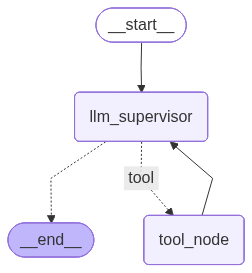

In [135]:
from langgraph.prebuilt import ToolNode

# class MessageState(TypedDict):
#     messages: Annotated[List[AnyMessage], operator.add]
    # Previously we used string based messages. now let's
toolworkflow=StateGraph(MessageState)

toolworkflow.add_node("llm_supervisor",supervisor)
toolworkflow.add_node("tool_node",tool_node)
toolworkflow.add_edge(START,"llm_supervisor")
toolworkflow.add_conditional_edges("llm_supervisor",router_function,
                                   {"tool":"tool_node",
                                    END:END}) #dirctly can mention the function details
toolworkflow.add_edge("tool_node","llm_supervisor")
# Compile the agent
agent = toolworkflow.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
agent.invoke({"messages":[HumanMessage(content="What is the  and Add 500 to it")]})

/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


{'messages': [HumanMessage(content='What is the price of iPhone 17 Pro Max In US and Add 500 to it', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kBuXMbEuRWk6HjPzk882gupi', 'function': {'arguments': '{"query": "price of iPhone 17 Pro Max in US"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 873, 'prompt_tokens': 263, 'total_tokens': 1136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 832, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_ddf739c152', 'id': 'chatcmpl-ClZ7TvU6C6CGNVkMzSxVb1TJkFQmL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b0d2a-8a16-7ca2-b70e-0ed953a6bef1-0', tool_calls=[{'name': 'duckduckgo_search', 'ar